In [1]:
%matplotlib inline

import sys
import os

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
from imageio import imread, imwrite
from skimage.transform import resize
sys.path.append('..')

import meters as ms
from meters.batch import MeterBatch
from meters.dataset import B,V,F,R,P, FilesIndex, Dataset, Pipeline
from meters.dataset.dataset.models.tf import ResNet18, MobileNet,DenseNet121, ResNet50, VGG19, MobileNet_v2, InceptionResNet_v2


plt.style.use('seaborn-poster')
plt.style.use('ggplot')

shape_to_feed = (200, 200)

images_folder = "/home/grisha/work/meters/newone/data/images"
labels_folder = "/home/grisha/work/meters/newone/data/labels"

clean_images_folder = "/home/grisha/work/meters/newone/data/images_clean"

/home/grisha/anaconda3/envs/tf/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Load pipeline for 'vacuum' meters

In [2]:
# vac_images = np.stack([imread('/home/grisha/Desktop/water_meters_vac/images_png/'+x) for x in sorted(os.listdir('/home/grisha/Desktop/water_meters_vac/images_png'))])

# labels = pd.read_csv('/home/grisha/Desktop/water_meters_vac/labels/labels.csv', index_col='file_name')

# coordinates = labels[['coordinates']].values.flatten()
# labels = labels[['labels']].values
# vac_dset = Dataset(index=np.arange(len(labels)),batch_class=MeterBatch)
# load_ppl =( \
#     Pipeline()\
#     .load(src=vac_images, components='images')
#     .load(src=coordinates, components='coordinates')
#     .convert_bbox(src='coordinates', dst='coordinates', sep=' ')\
#     .resize_bb_only(original_shape = (896,1600), shape=shape_to_feed,\
#                src='coordinates',\
#                dst='coordinates'))

# Preprocess images

In [3]:
# def remove_background(image, bbox):
#     """ Removes white stripes from the edges of an image."""
#     rows_mean, columns_mean = image.mean((1, 2)), image.mean((0, 2))
#     rows_nonwhite = np.argwhere(rows_mean < 250)
#     columns_nonwhite = np.argwhere(columns_mean < 250)

#     new_bbox = bbox.copy()

#     dr, dc = 0, 0
#     if rows_mean[0] > 250:
#         dr = rows_nonwhite[0][0]
        
#     if columns_mean[0] > 250:
#         dc = columns_nonwhite[0][0]
        

#     new_bbox[1] -= dr
#     new_bbox[0] -= dc

#     left_top = (rows_nonwhite[0][0], columns_nonwhite[0][0])
#     right_bottom = (rows_nonwhite[-1][0], columns_nonwhite[-1][0])

#     return image[left_top[0]:right_bottom[0], left_top[1]:right_bottom[1]].copy(), new_bbox


# labels = pd.read_csv(os.path.join(labels_folder, 'new_labels.csv'), index_col='file_name')
# images = [imread(os.path.join(images_folder, imname)) for imname in sorted(os.listdir(images_folder))]
# corrected_bboxes = {}
# for i in tqdm(range(len(labels))):
#     image = images[i]
#     bbox = labels.iloc[i]['coordinates']
#     name = labels[i:i+1].index[0]
    
#     image, bbox = remove_background(image, [float(x) for x in bbox.split(', ')])
#     bbox = np.round(bbox * np.tile(shape_to_feed, 2) / np.tile(image.shape[1::-1],2))
#     image = resize(image, shape_to_feed)
    
    
#     corrected_bboxes[name] = bbox
#     imwrite(os.path.join(clean_images_folder, name + '.png'), image)
# corrected_bboxes = pd.DataFrame.from_dict(corrected_bboxes, orient='index').sort_index()
# corrected_bboxes.index.name = 'file_name'
# corrected_bboxes.to_csv(os.path.join(labels_folder, 'corrected_bboxes.csv'))

# Generate augmented images

In [4]:
real_images = np.stack([imread(os.path.join(clean_images_folder, x))
               for x in sorted(os.listdir(clean_images_folder))])

corrected_bboxes = pd.read_csv(os.path.join(labels_folder, 'corrected_bboxes.csv'),
                               index_col='file_name').values

dset = Dataset(index=np.arange(len(real_images)), batch_class=MeterBatch)
dset.cv_split(0.5, shuffle=True)

test_load_ppl = \
    Pipeline()\
    .load(src=real_images, components='images')\
    .load(src=corrected_bboxes, components='coordinates')\
    .multiply(multiplier=1/255., preserve_type=False)\
    .normalize_bb(src=['images', 'coordinates'],\
                  dst=['images', 'coordinates'])
    
train_load_ppl = \
    Pipeline()\
    .load(src=real_images, components='images')\
    .load(src=corrected_bboxes, components='coordinates')\
    
    
def factor_sampler(size):
    return np.random.uniform(0.5, 1.5, (size,2))

def shift_sampler(size):
    return np.hstack((np.random.uniform(-30, 60, (size, 1)),\
                      np.random.uniform(-20, 20, (size, 1)),\
                      np.zeros((size, 1))))

def shape_sampler(size):
    return np.random.randint(10, 40, (size, 2, 2))

def color_sampler(size):
    return np.random.uniform(0, 1, (size, 2, 3))

mode_generator=lambda size: np.random.choice(['constant', 'nearest', 'wrap'], size)
 
augmentation_ppl = (\
    Pipeline()\
    .scale(factor=P(R(factor_sampler)),\
           src=['images', 'coordinates'],\
           dst=['images', 'coordinates'],\
           preserve_shape=True,
           mode=P(R(mode_generator)), p=0.6)\
    .shift(shift=P(R(shift_sampler)),\
           src=['images', 'coordinates'],\
           dst=['images', 'coordinates'],\
           mode=P(R(mode_generator)), p=0.6)\
    .rotate(angle=P(R('uniform',-10, 10)),\
            src=['images', 'coordinates'],\
            dst=['images', 'coordinates'],\
            p=0.6,
           mode=P(R(mode_generator)))\
    .multiply(multiplier=1/255., preserve_type=False)\
    .multiply(multiplier=P(R('uniform', 0.5, 1.5)), p=0.6)\
    .fill_crop(origins=['random'],\
               shapes=P(R(shape_sampler)),\
               colors=P(R(color_sampler)), p=0.6)\
    .salt(size=lambda: np.random.randint(1, 10, 2),\
          color=lambda: np.random.uniform(0, 1, 3),\
          p_noise=P(R('uniform', 0.0005, 0.001)),\
          p=0.5)\
    .posterize(colors_number=R('randint',32,254), p=0.1)\
    .multiplicative_noise(noise=lambda size: np.random.uniform(0.95, 1.05,size=size), p=0.5)\
    .additive_noise(noise=lambda size: np.random.normal(0, 0.005,size=size), p=0.5)\
    .normalize_bb(src=['images', 'coordinates'],\
                  dst=['images', 'coordinates']))

#train
bbox_pipeline = (train_load_ppl + augmentation_ppl) << dset.train
bboxes = dict()
for batch in tqdm(bbox_pipeline.gen_batch(batch_size=len(dset.train),
                                          n_epochs=100, shuffle=False,
                                          prefetch=1, drop_last=False)):
    names = ['aug' + str(x) for x in np.random.randint(10**14, 10**15, len(batch))]  
    for i in range(len(batch)):
        bboxes[names[i]] = batch.coordinates[i]
        imwrite('../newone/data/augmented_images/'+names[i]+'.png', batch.images[i])
(pd.DataFrame
     .from_dict(bboxes, orient='index')
     .sort_index()
     .to_csv('../newone/data/labels/aug_bboxes.csv'))

#test
bbox_pipeline = test_load_ppl << dset.test
bboxes = dict()
for batch in tqdm(bbox_pipeline.gen_batch(batch_size=len(dset.test),
                                          n_epochs=1, shuffle=False, drop_last=False)):
    names = ['aug' + str(x) for x in np.random.randint(10**14, 10**15, len(batch))]
    for i in range(len(batch)):
        bboxes[names[i]] = batch.coordinates[i]
        imwrite('../newone/data/test_aug/'+names[i]+'.png', batch.images[i])
(pd.DataFrame
     .from_dict(bboxes, orient='index')
     .sort_index()
     .to_csv('../newone/data/labels/aug_bboxes_test.csv'))

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

/home/grisha/anaconda3/envs/tf/lib/python3.5/site-packages/imageio/core/util.py:78: UserWarning: Lossy conversion from float64 to uint8, range [0, 1]
  dtype_str, out_type.__name__))


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

# train\test datasets

In [4]:
train_images = np.stack([imread('/home/grisha/work/meters/newone/data/augmented_images/'+x)
                         for x in sorted(os.listdir('/home/grisha/work/meters/newone/data/augmented_images/'))]).astype(np.uint8)
train_bboxes = pd.read_csv('/home/grisha/work/meters/newone/data/labels/aug_bboxes.csv', index_col=0).values
train_dset = Dataset(index=np.arange(len(train_images)), batch_class=MeterBatch)
train_load_ppl = \
    Pipeline()\
    .load(src=train_images, components='images')\
    .load(src=train_bboxes, components='coordinates')\
    .multiply(multiplier=1/255., preserve_type=False)
    
    
test_images = np.stack([imread('/home/grisha/work/meters/newone/data/test_aug/'+x) for x in sorted(os.listdir('/home/grisha/work/meters/newone/data/test_aug/'))])
test_bboxes = pd.read_csv('/home/grisha/work/meters/newone/data/labels/aug_bboxes_test.csv', index_col=0).values
test_dset = Dataset(index=np.arange(len(test_images)), batch_class=MeterBatch)
test_load_ppl = \
    Pipeline()\
    .load(src=test_images, components='images')\
    .load(src=test_bboxes, components='coordinates')\
    .multiply(multiplier=1/255., preserve_type=False)


# Datasets' images

In [5]:
from IPython.display import clear_output
from time import sleep

def add_bb(img, bb, c, width=3):
    lc, lr, w, h = bb.astype(np.int)
    im_height = img.shape[0] - 1
    im_width = img.shape[1] - 1
    for i in range(width):
        img[min(im_height,lr):min(im_height,lr)+i, min(im_width,lc):min(im_width,lc+w),:]=c
        img[min(im_height,lr):min(im_height,lr+h), min(im_width,lc):min(im_width,lc)+i,:]=c
        img[min(im_height,lr):min(im_height,lr+h), min(im_width,lc+w):min(im_width,lc+w)+i,:]=c
        img[min(im_height,lr+h):min(im_height,lr+h)+i, min(im_width,lc):min(im_width,lc+w),:]=c
    return img

def show_examples(ppl, n=20, test=False, sleep_=0.1, width=2):
    for _ in range(n):
        clear_output(True)
        batch = ppl.next_batch(2, shuffle=True)
        image = batch.images[0].copy()
        bbox = batch.coordinates[0] * np.tile(image.shape[1::-1], 2)
        plt.figure(figsize=(9,9))
        image = add_bb(image, bbox, [0,1,0], width)
        if test:
            bbox = ppl.get_variable('predictions')[0] * np.tile(image.shape[1::-1], 2)
            image = add_bb(image, bbox, [1,0,0], width)
            print('{:.2f}'.format(ppl.get_variable('current_iou')[0]))
        plt.imshow(image)
        
        plt.grid(False)
        plt.show()
        sleep(sleep_)
    

## train

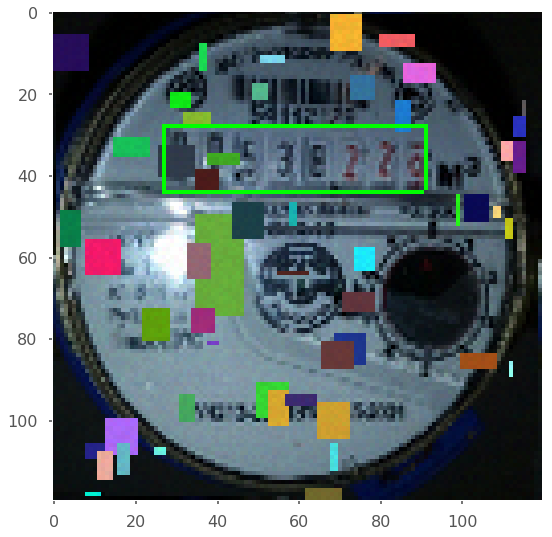

In [6]:
show_examples(train_load_ppl<<train_dset, 30, sleep_=0.1, width=2)

## test

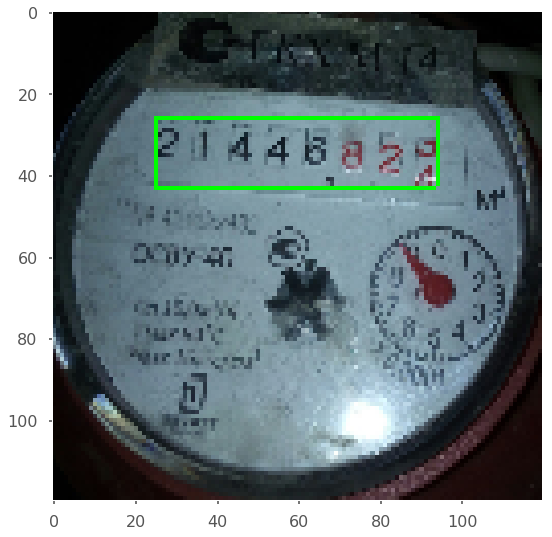

In [7]:
show_examples((test_load_ppl)<<test_dset, 30, sleep_=0.1, width=2)

# Bounding box regression

In [8]:
import tensorflow as tf
def smooth_l1(labels, predictions, mu=0.3, scope=None, *args, **kwargs):
    error = predictions - labels
    abs_error = tf.abs(error)
    quadratic = tf.minimum(mu, error)
    losses = quadratic ** 2 / (2 * mu) + abs_error - quadratic
    return tf.reduce_mean(losses)

In [9]:
batch_size = 50
epoch_size=len(train_dset) // batch_size

# learning rate decat values
values = list(7*np.array([0.01, 0.001, 0.0001, 0.00005, 0.00001]))
boundaries = list((epoch_size * np.array([25, 200, 300, 400])).astype(np.int32))

session_config = tf.ConfigProto()
session_config.gpu_options.allow_growth = True

train_ppl = (Pipeline()
         .init_variable('model_arch', MobileNet_v2)
         .init_variable('current_loss', init_on_each_run=0)
         .init_variable('current_iou', init_on_each_run=0)
         .init_variable('predictions', init_on_each_run=0)
         .init_model('dynamic', V('model_arch'), 'model',
                     config={'session' : {'config' : session_config},
#                              'body': {'width_factor' : 0.5},
                             'inputs' : {'images': {'shape': B('image_shape'),
                                                    'data_format': 'channels_last'},
                                         'labels': {'name': 'targets', 'shape' : (4,)}},
                             'loss' : {'name' : 'huber', 'delta' : 1.},
#                              'loss' : smooth_l1,
                             'decay' : {'name' : 'const',
                                        'boundaries' : boundaries,
                                        'values' : values},
#                              'optimizer' : {'name' : 'GradientDescent',
                             'optimizer': {'name' : 'Momentum', 'momentum' : 0.995, 'use_nesterov' : True,
                                           'learning_rate': 0.1},
                             'input_block/inputs' : 'images'})
           + train_load_ppl\
           + Pipeline()\
         .train_model('model', fetches=['loss', 'predictions'],
                      feed_dict={'images': B('images'),
                                 'labels': B('coordinates')},
                      save_to=[V('current_loss'), V('predictions')], use_lock=False)
         .iou()
        )
train_pipeline = train_ppl << train_dset




In [10]:
test_ppl =(Pipeline()\
         .import_model('model', train_pipeline)\
         .init_variable('current_iou', init_on_each_run=0)
         .init_variable('current_loss', init_on_each_run=0)
         .init_variable('predictions', init_on_each_run=0)\
         + test_load_ppl + Pipeline()\
         .predict_model('model', fetches=['loss', 'predictions'],\
                      feed_dict={'images': B('images'),\
                                 'labels': B('coordinates')},\
                      save_to=[V('current_loss'), V('predictions')])
         .iou())
test_pipeline = test_ppl << test_dset

In [11]:
def show_examples_val(ppl, a, width=2):
    for ai in a:
        batch = ppl.next_batch(1, shuffle=True, n_epochs=None)
        image = batch.images[0].copy()
        bbox = batch.coordinates[0] * np.tile(image.shape[1::-1], 2)
        plt.figure(figsize=(9,9))
        image = add_bb(image, bbox, [0,1,0], width)
        bbox = ppl.get_variable('predictions')[0] * np.tile(image.shape[1::-1], 2)
        image = add_bb(image, bbox, [1,0,0], width)
        ai.imshow(image);
        
        ai.grid(False);
        
def plot_metrics(loss, test_loss, iou, test_iou, show_img=False, ppl=None):
    if show_img==False:
        f, a = plt.subplots(1, 2, figsize=(16,9));
    else:
        f, a = plt.subplots(1, 2, figsize=(16, 5));
    x = np.arange(1, len(loss)+1)
    a = a.flatten()
    a[0].semilogy(x, loss, color='b', label='train')
    a[0].semilogy(x, test_loss, color='orange', label='test')
    a[0].legend()
    a[0].set_title('loss', fontsize=18)
    a[1].plot(x, iou, label='train', color='b')
    a[1].plot(x, test_iou, label='test', color='orange')
    a[1].legend()
    a[1].set_title('iou', fontsize=18)
    if show_img:
        f, a = plt.subplots(10, 3, figsize=(16, 64));
        show_examples_val(ppl, a.flatten());
    plt.show();
    print('-'*50)
    
def validate(ppl):
    iou, loss = 0, 0
    for i, tb in enumerate(ppl.gen_batch(batch_size=batch_size, n_epochs=1, drop_last=False), 1):
        iou += ppl.get_variable('current_iou')
        loss += ppl.get_variable('current_loss')
    return iou / i, loss / i

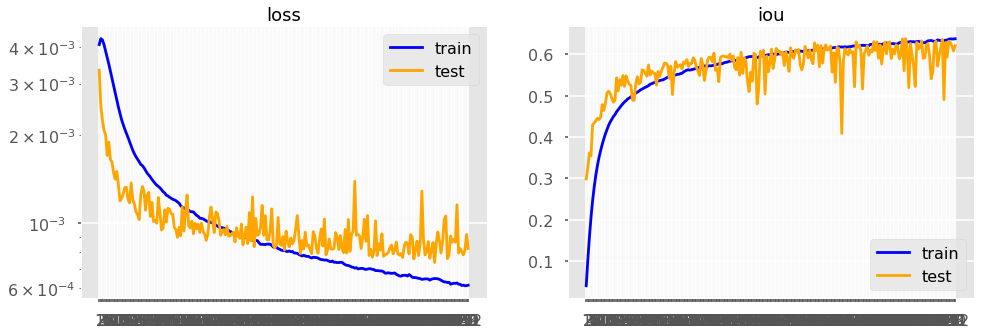

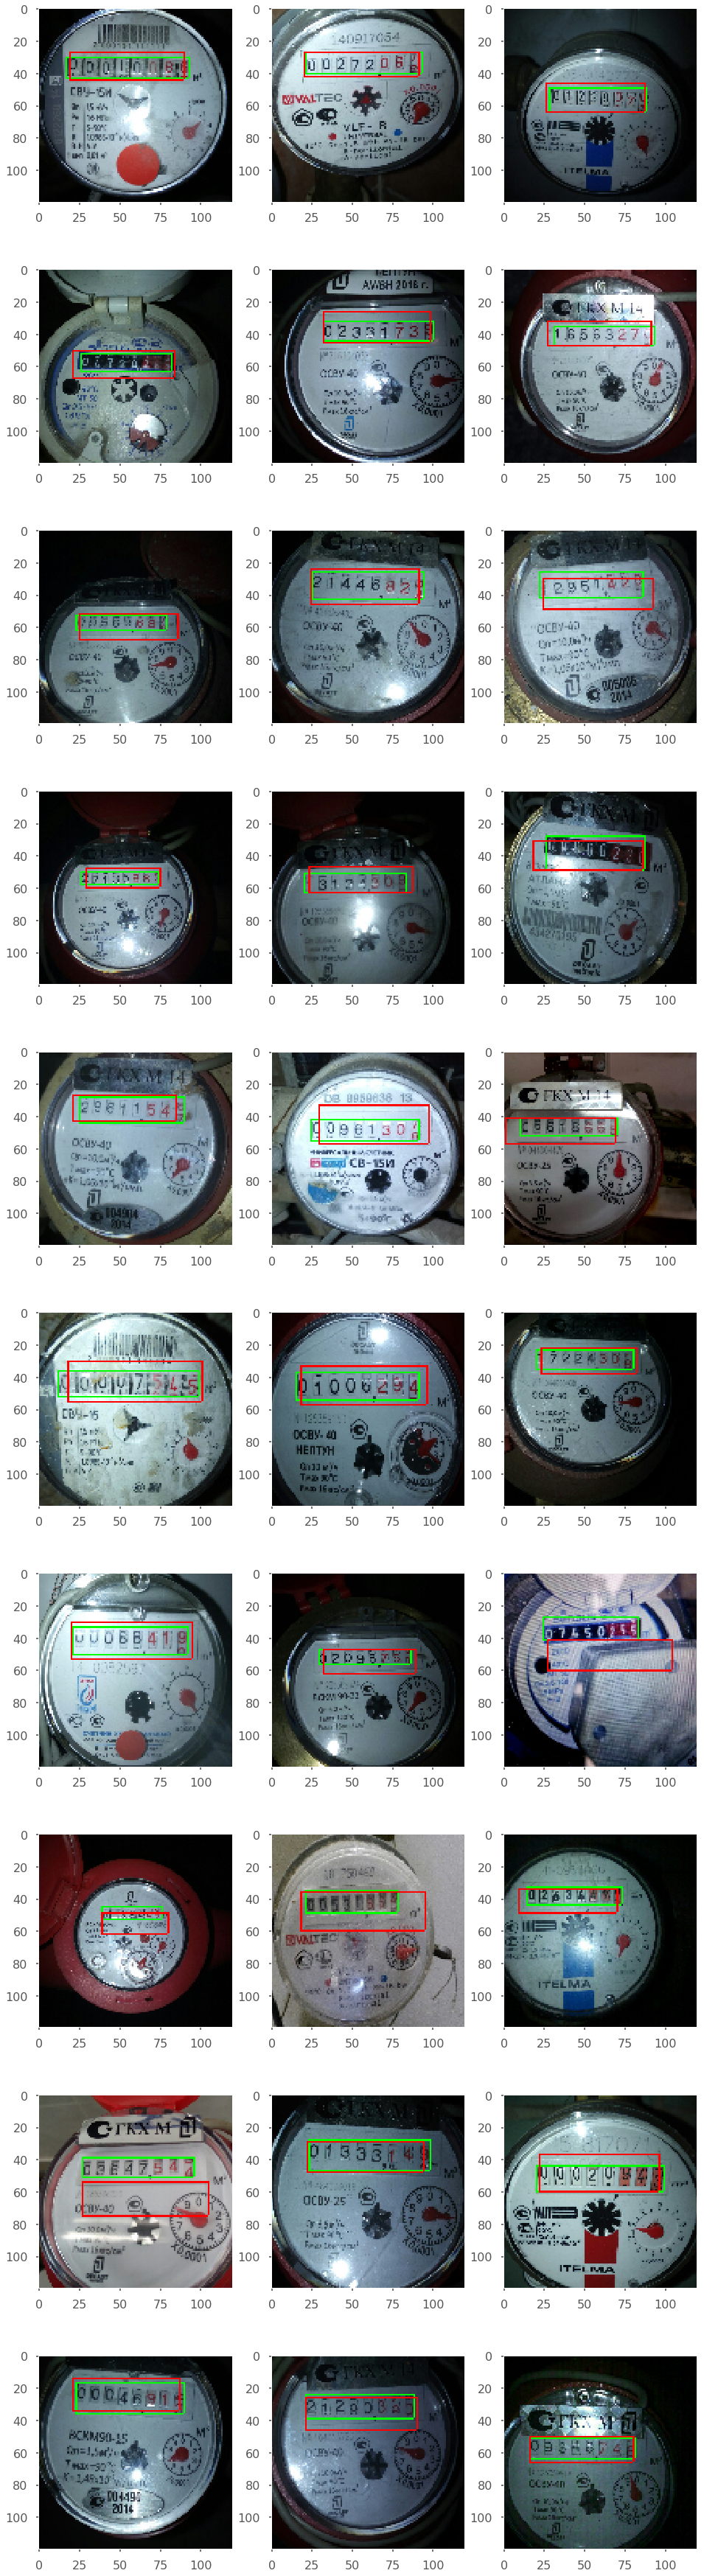

--------------------------------------------------


KeyboardInterrupt: 

In [12]:
alpha = 1 / 100

iou_value = 0
loss_value = 0

losses = []
test_losses = []
iou_values = []
iou_test_values = []


log_file = 'train_log.txt'
with open(log_file, 'w') as f:
    f.write('each epoch lasts for {} iterations\n'.format(epoch_size))


for i, b in tqdm(enumerate(train_pipeline.gen_batch(batch_size=batch_size,
                                                    shuffle=True,
                                                    n_epochs=500,
                                                    drop_last=False,
                                                    prefetch=0), 1)):
    loss_value = (1 - alpha) * loss_value + alpha * train_pipeline.get_variable('current_loss')
    iou_value = (1 - alpha) * iou_value + alpha * train_pipeline.get_variable('current_iou')
    
    if i % 10 == 0 and i < 51:
         print(i, 'train loss: {:.1e}'.format(loss_value), 'train iou: {:.2f}'.format(iou_value))
            
    if i % (epoch_size // 10) == 0:
        losses.append(loss_value)
        iou_values.append(iou_value)

        iou, loss = validate(test_pipeline)
        iou_test_values.append(iou)
        test_losses.append(loss)
        
        clear_output(True)
        log = 'epoch {0:d}: train loss: {:.2e}, test loss: {:.2e}, train iou: {:.2e}, test iou: {:.2e}\n'\
            .format(i // epoch_size, loss_value, test_losses[-1], iou_value, iou_test_values[-1])
            
        with open(log_file, 'w') as f:
            f.write(log)
            
        plot_metrics(losses, test_losses, iou_values, iou_test_values, show_img=True, ppl=test_pipeline);